In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd ..

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR


In [7]:
from data_generation import *
from upscaling import *
import torch
from torch import cuda
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as sn

In [4]:
# Initialisation
N_low = 16
N_high = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

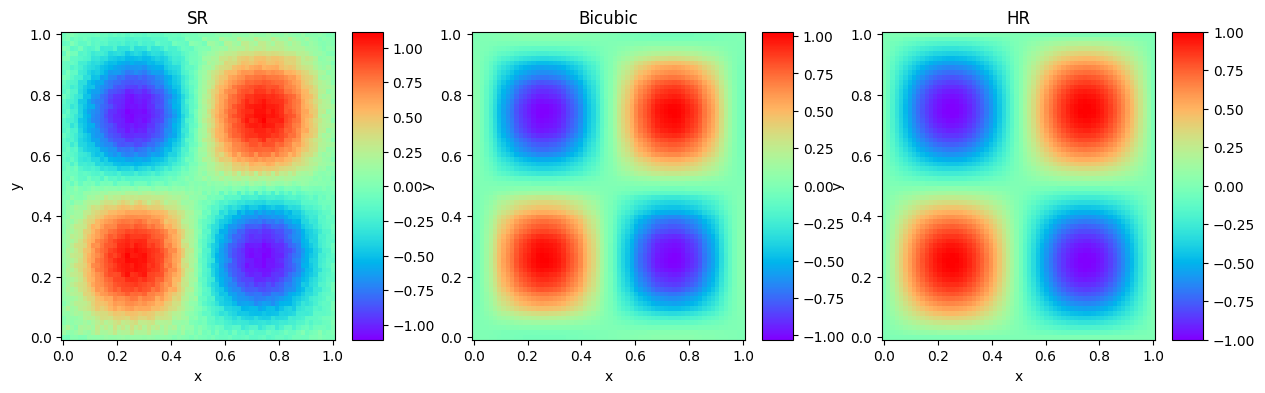

SR L2 Error: 0.0050808549640700825
Bicubic L2 Error: 0.005068267802171567


In [10]:
G = UpScaleBy4().to(device)
G.load_state_dict(torch.load('models/pairs_training/100samples_scaleby4/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(N_high,N_high), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

In [6]:
h_low = 1/(N_low-1)
h_high = 1/(N_high-1)

G = gaussian_kernal(x_low,y_low,GP_l,GP_sigma,N_low)

r_low_sample = np.random.multivariate_normal(r_low.ravel(),G)
r_high_sample = cv2.resize(r_low_sample.reshape(N_low,N_low), dsize=(N_high,N_high), interpolation=cv2.INTER_CUBIC)/(h_low**2) * (h_high**2)
r_high_sample = r_high_sample.reshape(-1,1)

C = np.linalg.solve(A_high,r_high_sample)
w_high_sample = C.reshape((N_high,N_high))

C = np.linalg.solve(A_low,r_low_sample)
w_low_sample = C.reshape((N_low,N_low))

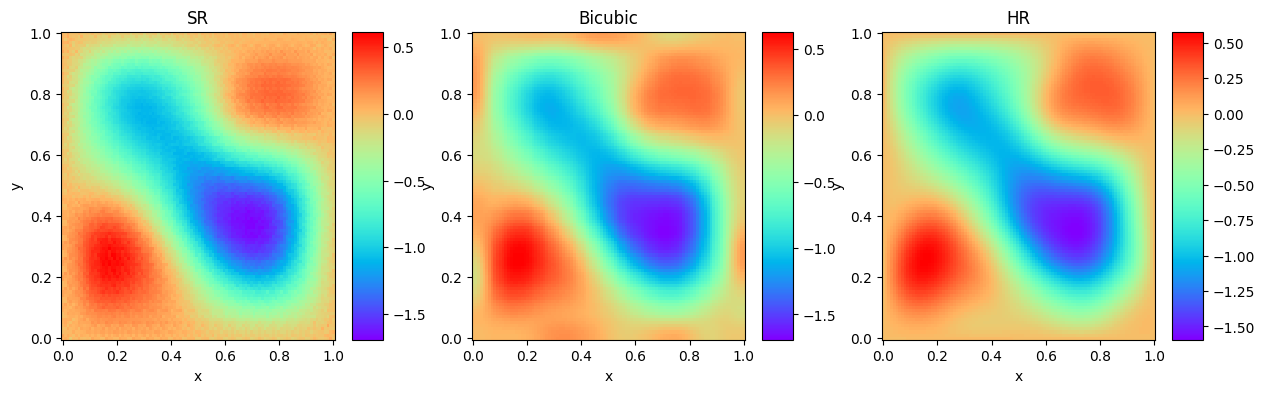

SR L2 Error: 0.003913614492317064
Bicubic L2 Error: 0.004394433809968877


In [7]:
G = UpScale().to(device)
G.load_state_dict(torch.load('models/pairs_training/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
input = w_low_sample
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low_sample, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high_sample, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high_sample - y[0])
error2 = abs(w_high_bicubic - w_high_sample)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)